In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 

In [35]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [36]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [49]:
#filtering data to have similar chirp structure and eliminating redundancies in pulse pause and duration

def filter_data(x, dur_max):
    pd_df = x
    (uniq, freq) = (np.unique(pd_df.CDUR, return_counts=True))
    xa = np.array([uniq,freq])
    xa = xa.astype(int)

    jo = np.zeros(np.max(xa[0]))
    jo[xa[0]-1] = freq
    jo2 = []
    for i in range(30,len(jo)-30):
        jo2.append([i, np.sum(jo[i-30:i+30])])
    jo2 = np.array(jo2).T

    j = np.where(jo2 == np.max(jo2[1]))
    val = j[1][1] + 31

    x = pd_df.CDUR
    x1 = x>=(val-30)
    xa = pd_df[x1]
    x2 = xa.CDUR<=(val+30)
    xb = xa[x2]

    pd_df = xb
    (uniq, freq) = (np.unique(pd_df.CPAU, return_counts=True))
    xa = np.array([uniq,freq])
    xa = xa.astype(int)

    jo = np.zeros(np.max(xa[0]))
    jo[xa[0]-1] = freq
    jo2 = []
    for i in range(30,len(jo)-30):
        jo2.append([i, np.sum(jo[i-30:i+30])])
    jo2 = np.array(jo2).T

    j = np.where(jo2 == np.max(jo2[1]))
    val = j[1][1] + 31

    x = pd_df.CPAU
    x1 = x>=(val-30)
    xa = pd_df[x1]
    x2 = xa.CPAU<=(val+30)
    xb = xa[x2]

    dfa = pd.DataFrame([xb.PDUR, xb.PPAU, xb.rXY]).T
    dfx = dfa.groupby(['PPAU', 'PDUR']).mean().reset_index()
    
    check = dfx<=dur_max
    df_c = np.all(check,1)
    dfx = dfx[df_c]
    
    dfx = np.array([dfx.PDUR, dfx.PPAU, dfx.rXY]).T
    return dfx


In [64]:
#Importing data from file

def import_data(dur_max, dur_step):

    pd_df = pd.read_csv("dat/FIR.txt")
    df = filter_data(pd_df, dur_max)
    
    edg = [[0,0,0]]#, [0, dur_max-1, 0], [dur_max-1, dur_max-1, 0], [dur_max-1,0,0]]
    df = np.append(df, edg, axis = 0) #[20, 20, 0],
    
    df = df.T
    pdur = df[0]
    ppau = df[1]
    phonotaxis = df[2]

    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = 0 #np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    
    ppf /= np.max(ppf)
    return ppf


In [68]:
#defining some global variables that are constant and used throughout the code

dur_max = 80  # ms
dur_step = 2  # ms
global pnt_ori, pdur_i, ppau_i
pnt_ori = import_data(dur_max, dur_step)
pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

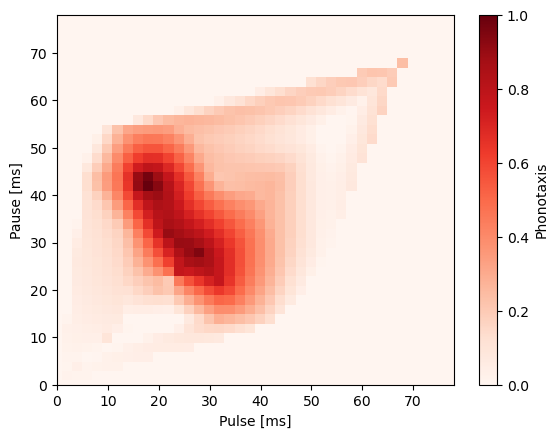

In [69]:
#For reference
plot_field(pdur_i, ppau_i, pnt_ori)

In [70]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [71]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [72]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [73]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [74]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [75]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

0.3158216956850382


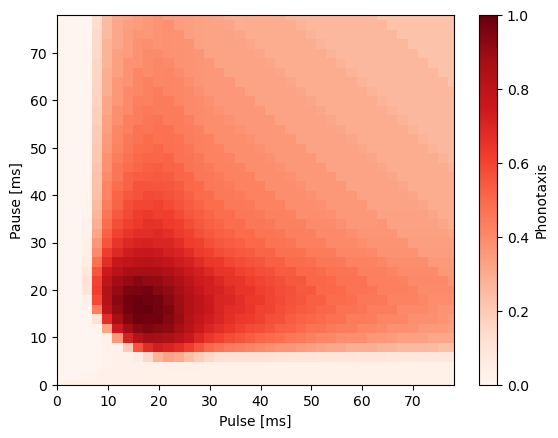

In [76]:
#setting initial values. and printing the start point of the minimize function present below
cfg = [30, 10, 1, 0.01, 2, 20]
y = sig_diff(cfg)
print(y)
xz = sig_diff2(cfg)
plot_field(pdur_i, ppau_i, xz[1])

In [77]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [78]:
#bounds of each parameter

b_fr = (0, 300)
b_sigma = (1, 101)
b_phi = (0, 2)
b_w = (-0.1, 0.1)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


#Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. , 'maxfev':1500  'options' : {"disp": True},  'bounds' : bnds, 
result = spo.basinhopping(sig_diff, cfg, niter = 10, minimizer_kwargs={'options' : {"disp": True}, 'bounds' : bnds,  'method' : 'L-BFGS-B'})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15822D-01    |proj g|=  2.46446D-01

At iterate    1    f=  2.25819D-01    |proj g|=  8.38144D-02

At iterate    2    f=  2.24986D-01    |proj g|=  1.32329D-01

At iterate    3    f=  2.23554D-01    |proj g|=  1.90853D-01

At iterate    4    f=  2.00519D-01    |proj g|=  1.36167D-01

At iterate    5    f=  1.99751D-01    |proj g|=  1.02799D-01

At iterate    6    f=  1.99540D-01    |proj g|=  9.30694D-02

At iterate    7    f=  1.98984D-01    |proj g|=  1.68773D-02

At iterate    8    f=  1.98628D-01    |proj g|=  6.97410D-02

At iterate    9    f=  1.97530D-01    |proj g|=  7.10580D-02

At iterate   10    f=  1.91328D-01    |proj g|=  9.59138D-02

At iterate   11    f=  1.90499D-01    |proj g|=  1.17185D-01

At iterate   12    f=  1.90313D-01    |proj g|=  7.09792D-02

At iterate   13    f=  1.9


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   38    f=  1.77998D-01    |proj g|=  1.81097D-03

At iterate   39    f=  1.77998D-01    |proj g|=  1.80811D-03

At iterate   40    f=  1.77998D-01    |proj g|=  5.69446D-03

At iterate   41    f=  1.77997D-01    |proj g|=  1.09414D-02

At iterate   42    f=  1.77996D-01    |proj g|=  1.47957D-02

At iterate   43    f=  1.77995D-01    |proj g|=  1.14208D-02

At iterate   44    f=  1.77993D-01    |proj g|=  3.57865D-03

At iterate   45    f=  1.77992D-01    |proj g|=  8.07429D-03

At iterate   46    f=  1.77991D-01    |proj g|=  1.65358D-02

At iterate   47    f=  1.77988D-01    |proj g|=  3.10671D-02

At iterate   48    f=  1.77982D-01    |proj g|=  5.14239D-02

At iterate   49    f=  1.77964D-01    |proj g|=  8.27728D-02

At iterate   50    f=  1.77925D-01    |proj g|=  8.47604D-02

At iterate   51    f=  1.77846D-01    |proj g|=  8.50018D-02

At iterate   52    f=  1.77746D-01    |proj g|=  8.48917D-02

At iterate   53    f=  1.77737D-01    |proj g|=  8.46243D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   81    f=  1.03103D-01    |proj g|=  6.62319D-02

At iterate   82    f=  1.03024D-01    |proj g|=  6.24132D-02

At iterate   83    f=  1.02971D-01    |proj g|=  4.69438D-02

At iterate   84    f=  1.02891D-01    |proj g|=  3.81870D-02

At iterate   85    f=  1.02862D-01    |proj g|=  1.44147D-02

At iterate   86    f=  1.02841D-01    |proj g|=  1.42863D-02

At iterate   87    f=  1.02574D-01    |proj g|=  5.06510D-02

At iterate   88    f=  1.02074D-01    |proj g|=  1.02845D-01

At iterate   89    f=  9.89356D-02    |proj g|=  1.79865D-01

At iterate   90    f=  9.87129D-02    |proj g|=  7.47512D-02

At iterate   91    f=  9.86372D-02    |proj g|=  1.90134D-02

At iterate   92    f=  9.86315D-02    |proj g|=  1.35150D-02

At iterate   93    f=  9.86216D-02    |proj g|=  1.02996D-02

At iterate   94    f=  9.86147D-02    |proj g|=  9.35032D-03

At iterate   95    f=  9.86136D-02    |proj g|=  1.53721D-03

At iterate   96    f=  9.86136D-02    |proj g|=  6.22388D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  119    f=  9.81978D-02    |proj g|=  8.08177D-02

At iterate  120    f=  9.81919D-02    |proj g|=  7.24331D-02

At iterate  121    f=  9.81910D-02    |proj g|=  2.98571D+01

At iterate  122    f=  9.81887D-02    |proj g|=  6.72657D-02

At iterate  123    f=  9.81768D-02    |proj g|=  4.31479D-02

At iterate  124    f=  9.81737D-02    |proj g|=  5.54661D-02

At iterate  125    f=  9.81372D-02    |proj g|=  1.77854D-02

At iterate  126    f=  9.81145D-02    |proj g|=  2.62868D-02

At iterate  127    f=  9.81030D-02    |proj g|=  2.59638D-02

At iterate  128    f=  9.80243D-02    |proj g|=  6.53273D-02

At iterate  129    f=  9.79188D-02    |proj g|=  1.89226D-03

At iterate  130    f=  9.79188D-02    |proj g|=  6.30243D-04

At iterate  131    f=  9.79188D-02    |proj g|=  6.45942D-04

At iterate  132    f=  9.79187D-02    |proj g|=  6.28091D-04

At iterate  133    f=  9.79154D-02    |proj g|=  2.45962D-04

At iterate  134    f=  9.79146D-02    |proj g|=  2.39604D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  142    f=  9.77811D-02    |proj g|=  6.20712D-03

At iterate  143    f=  9.77809D-02    |proj g|=  3.19761D-03

At iterate  144    f=  9.77807D-02    |proj g|=  3.29954D-03

At iterate  145    f=  9.77798D-02    |proj g|=  1.18756D-02

At iterate  146    f=  9.77780D-02    |proj g|=  2.18408D-02

At iterate  147    f=  9.77734D-02    |proj g|=  2.45656D-02

At iterate  148    f=  9.77644D-02    |proj g|=  2.47619D-02

At iterate  149    f=  9.77450D-02    |proj g|=  2.50870D-02

At iterate  150    f=  9.77078D-02    |proj g|=  2.57111D-02

At iterate  151    f=  9.76750D-02    |proj g|=  2.60254D-02

At iterate  152    f=  9.76613D-02    |proj g|=  1.03581D-02

At iterate  153    f=  9.76580D-02    |proj g|=  2.28368D-03

At iterate  154    f=  9.76578D-02    |proj g|=  8.47795D-04

At iterate  155    f=  9.76577D-02    |proj g|=  5.79130D-04

At iterate  156    f=  9.76575D-02    |proj g|=  3.69260D-03

At iterate  157    f=  9.76573D-02    |proj g|=  6.72105D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  183    f=  9.73812D-02    |proj g|=  4.69827D-02

At iterate  184    f=  9.73779D-02    |proj g|=  3.66022D-02

At iterate  185    f=  9.73757D-02    |proj g|=  2.83751D-02

At iterate  186    f=  9.73755D-02    |proj g|=  2.78006D-02

At iterate  187    f=  9.73755D-02    |proj g|=  2.77807D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate  188    f=  9.73755D-02    |proj g|=  2.77802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6    188    593    194     1     0   2.778D-02   9.738D-02
  F =   9.7375517708249482E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15945D-01    |proj g|=  1.17001D-01

At iterate    1    f=  1.02138D-01    |proj g|=  6.10319D-02

At iterate    2    f=  1.02120D-01    |proj g|=  4.32286D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  9.58810D-02    |proj g|=  2.23522D-03

At iterate   37    f=  9.58809D-02    |proj g|=  1.80305D-03

At iterate   38    f=  9.58809D-02    |proj g|=  1.79726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38    124     40     0     0   1.797D-03   9.588D-02
  F =   9.5880911425660076E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92135D-01    |proj g|=  1.96215D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   49    f=  9.51712D-02    |proj g|=  3.06442D-03

At iterate   50    f=  9.51707D-02    |proj g|=  2.53963D-03

At iterate   51    f=  9.51686D-02    |proj g|=  1.33541D-03

At iterate   52    f=  9.51676D-02    |proj g|=  1.55576D-03

At iterate   53    f=  9.51604D-02    |proj g|=  3.01332D-03

At iterate   54    f=  9.51581D-02    |proj g|=  1.30658D-03

At iterate   55    f=  9.51578D-02    |proj g|=  2.63041D-04

At iterate   56    f=  9.51577D-02    |proj g|=  5.13600D-04

At iterate   57    f=  9.51576D-02    |proj g|=  9.85378D-04

At iterate   58    f=  9.51573D-02    |proj g|=  1.41013D-03

At iterate   59    f=  9.51569D-02    |proj g|=  1.35086D-03

At iterate   60    f=  9.51569D-02    |proj g|=  1.37853D-03

At iterate   61    f=  9.51566D-02    |proj g|=  6.90506D-04

At iterate   62    f=  9.51565D-02    |proj g|=  1.05010D-04

At iterate   63    f=  9.51565D-02    |proj g|=  2.11799D-04

At iterate   64    f=  9.51565D-02    |proj g|=  3.85755D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   68    f=  9.51556D-02    |proj g|=  2.88640D-03

At iterate   69    f=  9.51555D-02    |proj g|=  2.54496D-03

At iterate   70    f=  9.51552D-02    |proj g|=  1.06241D-04

At iterate   71    f=  9.51552D-02    |proj g|=  1.06325D-04

At iterate   72    f=  9.51552D-02    |proj g|=  2.75445D-04

At iterate   73    f=  9.51551D-02    |proj g|=  4.19770D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   74    f=  9.51551D-02    |proj g|=  1.05408D-03

At iterate   75    f=  9.51551D-02    |proj g|=  1.04625D-04

At iterate   76    f=  9.51551D-02    |proj g|=  1.04847D-04

At iterate   77    f=  9.51551D-02    |proj g|=  1.04848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     77    221     81     0     0   1.048D-04   9.516D-02
  F =   9.5155079264833825E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57060D-01    |proj g|=  1.62865D-01

At iterate    1    f=  1.05365D-01    |proj g|=  2.00000D-01

At iterate    2    f=  1.04236D-01    |proj g|=  1.70406D-01

At iterate    3    f=  1.03002D-01    |proj g|=  5.00344D-02

At iterate    4    f=  1.02021D-01    |proj g|=  3.09425D-02

At iterate    5    f=  1.01144D-01    |proj g|=  2.15302D-02

At iterate    6    f=  1.00501D-01    |proj g|=  1.90690D-01

At iterate    7    f=  1.00152D-01    |proj g|=  1.89405D-01

At iterate    8    f=  9.95617D-02    |proj g|=  1.87496D-01

At iterate    9    f=  9.86253D-02    |proj g|=  5.63701D-02

At iterate   10    f=  9.85267D-02    |proj g|=  1.98909D-02

At iterate   11    f=  9.84142D-02    |proj g|=  2.26187D-02

At iterate   12    f=  9.81479D-02    |proj g|=  1.76737D-01

At iterate   13    f=  9.7


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   42    f=  9.51688D-02    |proj g|=  1.18180D-03

At iterate   43    f=  9.51684D-02    |proj g|=  1.18111D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   44    f=  9.51684D-02    |proj g|=  1.17330D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   45    f=  9.51684D-02    |proj g|=  1.17325D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45    167     48     0     0   1.173D-03   9.517D-02
  F =   9.5168434720540387E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.38797D-01    |proj g|=  2.00000D-01

At iterate    1    f=  9.98130D-02    |proj g|=  1.72253D-01

At iterate    2    f=  9.70601D-02    |proj g|=  4.12762D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  9.56755D-02    |proj g|=  2.75328D-02

At iterate   37    f=  9.56755D-02    |proj g|=  2.75065D-02

At iterate   38    f=  9.56755D-02    |proj g|=  2.75057D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38    164     40     0     0   2.751D-02   9.568D-02
  F =   9.5675502311686159E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29586D-01    |proj g|=  1.77902D-01

At iterate    1    f=  1.82756D-01    |proj g|=  2.00000D-01

At iterate    2    f=  1.05383D-01    |proj g|=  1.57457D-01

At iterate    3    f=  1.03612D-01    |proj g|=  1.53988D-01

At iterate    4    f=  1.03308D-01    |proj g|=  4.82925D-02

At iterate    5    f=  1.03270D-01    |proj g|=  4.79904D-02

At iterate    6    f=  1.03031D-01    |proj g|=  4.55448D-02

At iterate    7    f=  1.02478D-01    |proj g|=  1.56506D-01

At iterate    8    f=  1.01272D-01    |proj g|=  1.62810D-01

At iterate    9    f=  1.00331D-01    |proj g|=  1.73516D-01

At iterate   10    f=  9.93328D-02    |proj g|=  1.72165D-01

At iterate   11    f=  9.72108D-02    |proj g|=  2.50156D-02

At iterate   12    f=  9.71316D-02    |proj g|=  2.05000D-02

At iterate   13    f=  9.7


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   49    f=  9.51726D-02    |proj g|=  1.70490D-03

At iterate   50    f=  9.51726D-02    |proj g|=  1.62415D-03

At iterate   51    f=  9.51725D-02    |proj g|=  1.83715D-03

At iterate   52    f=  9.51723D-02    |proj g|=  2.89581D-03

At iterate   53    f=  9.51723D-02    |proj g|=  2.70816D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   54    f=  9.51723D-02    |proj g|=  1.71172D-03

At iterate   55    f=  9.51723D-02    |proj g|=  7.66121D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   56    f=  9.51723D-02    |proj g|=  7.11343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     56    190     60     0     0   7.113D-04   9.517D-02
  F =   9.5172296979913029E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.43212D-01    |proj g|=  2.00000D-01

At iterate    1    f=  1.32499D-01    |proj g|=  2.00000D-01

At iterate    2    f=  1.10902D-01    |proj g|=  1.78007D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   41    f=  9.52088D-02    |proj g|=  3.20359D-03

At iterate   42    f=  9.52087D-02    |proj g|=  3.03685D-03

At iterate   43    f=  9.52081D-02    |proj g|=  5.46896D-03

At iterate   44    f=  9.52076D-02    |proj g|=  5.50979D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  9.52075D-02    |proj g|=  9.82049D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   46    f=  9.52075D-02    |proj g|=  9.82132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46    183     50     0     0   9.821D-04   9.521D-02
  F =   9.5207510497891418E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.21414D-01    |proj g|=  2.00000D-01

At iterate    1    f=  1.21012D-01    |proj g|=  4.49058D-02

At iterate    2    f=  1.20840D-01    |proj g|=  4.29064D-02

At iterate    3    f=  1.20556D-01    |proj g|=  1.01866D-01

At iterate    4    f=  1.19153D-01    |proj g|=  1.97941D-01

At iterate    5    f=  1.16844D-01    |proj g|=  1.96247D-01

At iterate    6    f=  1.10965D-01    |proj g|=  1.85484D-01

At iterate    7    f=  1.04471D-01    |proj g|=  1.69769D-01

At iterate    8    f=  9.96426D-02    |proj g|=  1.59406D-01

At iterate    9    f=  9.82930D-02    |proj g|=  3.97324D-02

At iterate   10    f=  9.82133D-02    |proj g|=  1.72264D-02

At iterate   11    f=  9.82100D-02    |proj g|=  1.78154D-02

At iterate   12    f=  9.72574D-02    |proj g|=  1.44915D-02

At iterate   13    f=  9.5


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   32    f=  9.51446D-02    |proj g|=  2.68361D-03

At iterate   33    f=  9.51446D-02    |proj g|=  1.28184D-03

At iterate   34    f=  9.51446D-02    |proj g|=  1.34387D-03

At iterate   35    f=  9.51444D-02    |proj g|=  4.04375D-03

At iterate   36    f=  9.51441D-02    |proj g|=  7.68150D-03

At iterate   37    f=  9.51433D-02    |proj g|=  1.18716D-02

At iterate   38    f=  9.51422D-02    |proj g|=  1.30973D-02

At iterate   39    f=  9.51398D-02    |proj g|=  1.46110D-02

At iterate   40    f=  9.51362D-02    |proj g|=  1.07038D-02

At iterate   41    f=  9.51351D-02    |proj g|=  3.53873D-03

At iterate   42    f=  9.51350D-02    |proj g|=  3.11863D-04

At iterate   43    f=  9.51350D-02    |proj g|=  4.61323D-04

At iterate   44    f=  9.51350D-02    |proj g|=  5.62191D-04

At iterate   45    f=  9.51349D-02    |proj g|=  7.77937D-04

At iterate   46    f=  9.51347D-02    |proj g|=  3.55311D-03

At iterate   47    f=  9.51343D-02    |proj g|=  2.33950D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   58    f=  9.51300D-02    |proj g|=  2.91936D-03

At iterate   59    f=  9.51299D-02    |proj g|=  2.78649D-03

At iterate   60    f=  9.51294D-02    |proj g|=  3.83757D-03

At iterate   61    f=  9.51291D-02    |proj g|=  4.03696D-03

At iterate   62    f=  9.51289D-02    |proj g|=  3.15296D-04

At iterate   63    f=  9.51289D-02    |proj g|=  4.82367D-04

At iterate   64    f=  9.51289D-02    |proj g|=  1.12720D-03

At iterate   65    f=  9.51289D-02    |proj g|=  2.13704D-03

At iterate   66    f=  9.51288D-02    |proj g|=  3.49013D-03

At iterate   67    f=  9.51286D-02    |proj g|=  4.78052D-03

At iterate   68    f=  9.51284D-02    |proj g|=  4.72211D-03

At iterate   69    f=  9.51282D-02    |proj g|=  2.79417D-03

At iterate   70    f=  9.51281D-02    |proj g|=  1.06730D-03

At iterate   71    f=  9.51280D-02    |proj g|=  1.71890D-03

At iterate   72    f=  9.51279D-02    |proj g|=  2.29021D-03

At iterate   73    f=  9.51278D-02    |proj g|=  2.48360D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   82    f=  9.51275D-02    |proj g|=  2.40736D-03

At iterate   83    f=  9.51275D-02    |proj g|=  6.65232D-04

At iterate   84    f=  9.51275D-02    |proj g|=  6.33148D-04

At iterate   85    f=  9.51274D-02    |proj g|=  1.11437D-03

At iterate   86    f=  9.51274D-02    |proj g|=  8.75303D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   87    f=  9.51274D-02    |proj g|=  6.68202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     87    198     92     0     0   6.682D-04   9.513D-02
  F =   9.5127419555656928E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17860D-01    |proj g|=  1.34925D-01

At iterate    1    f=  1.15459D-01    |proj g|=  7.50476D-02

At iterate    2    f=  1.14999D-01    |proj g|=  6.20562D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   47    f=  9.51932D-02    |proj g|=  1.56960D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48    149     51     0     0   1.570D-02   9.519D-02
  F =   9.5193231895848537E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10471D-01    |proj g|=  2.62192D-01

At iterate    1    f=  1.32158D-01    |proj g|=  2.00000D-01

At iterate    2    f=  1.02120D-01    |proj g|=  1.77091D-01

At iterate    3    f=  9.91552D-02    |proj g|=  3.59475D-02

At iterate    4    f=  9.91154D-02    |proj g|=  3.40139D-02

At iterate    5    f=  9.72738D-02    |proj g|=  3.22013D-02

At iterate    6    f=  9.69968D-02    |proj g|=  3.09010D-02

At iterate    7    f=  9.68423D-02    |proj g|=  1.14110D-02

At iterate    8    f=  9.68392D-02    |proj g|=  8.69792D-03

At iterate    9    f=  9.67492D-02    |proj g|=  3.22389D-02

At iterate   10    f=  9.64443D-02    |proj g|=  4.83179D-02

At iterate   11    f=  9.61543D-02    |proj g|=  2.33344D-02

At iterate   12    f=  9.60908D-02    |proj g|=  1.14773D-02

At iterate   13    f=  9.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   31    f=  9.56341D-02    |proj g|=  4.63840D-03

At iterate   32    f=  9.56341D-02    |proj g|=  4.57669D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   33    f=  9.56341D-02    |proj g|=  4.57645D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33    140     35     0     0   4.576D-03   9.563D-02
  F =   9.5634073439343589E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.09512741955565693
                          x: [ 1.739e+01  3.114e+01  1.272e+00 -6.840e-02
                               1.630e+00  3.173e+01]
                        nit: 10
      minimization_failures: 1
                       nfev: 15127
                       njev: 2161
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.09512741955565693
                                    x: [ 1.739e+01  3.114e+01  1.272e+00
                                        -6.840e-02  1.630e+00  3.173e+01]
                                  nit: 87
                                  jac: [ 5.792e-05  3.561e-05  1.123e-04
                                         6.682e-04  5.521e-05  1.

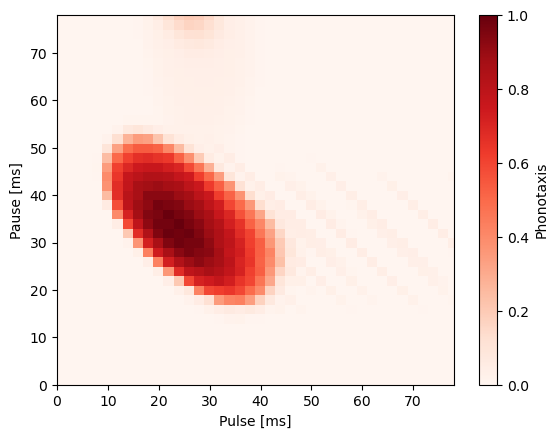

In [80]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xe = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xe[1])

In [223]:
# cfg1 = [1,0,0]
# vals = []
# for i in range(100, 160):
#     print(i)
#     for j in range(10, 35):
#         cfg = [i, j, 0, 0, 0.05, 1]
#         x = sig_diff(cfg)
#         vals.append(x)
#         if cfg1[0] > x:
#             cfg1 = [x, i, j]
    
# print(cfg1)
# plt.plot(vals)
# plt.show()